In [1]:
import time
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import matplotlib.gridspec as gridspec
# import matplotlib.patches as mpatches
# import matplotlib.dates as mdates
# import copy
# import seaborn as sns
%matplotlib inline

In [2]:
PHASE = 'Summer'
# PHASE = 'Winter'

tracker = 'PyFLEXTRKR'

# Specify regions
if PHASE == 'Summer':
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
    year = 2016
if PHASE == 'Winter':
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]
    year = 2020
    
# Ocean vs. Land threshold (%)
ocean_thresh = 99
land_thresh = 20

dir_root = '/pscratch/sd/f/feng045/DYAMOND/'
dir_dpr = f'{dir_root}GPM_DYAMOND/DPR/'
dir_dpr_phase = f'{dir_dpr}{year}/'
# basename_dpr = '2A.GPM.DPR.V9-20211125.20200131-S010102-E023334.033655.V07A_'
basename_dpr = '2A.GPM.DPR.V9-20211125.'

dir_imerg = '/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined/'
file_imerg = f'{dir_imerg}olr_pcp_{PHASE}_OBS.nc'
file_imergv7 = f'{dir_imerg}olr_pcp_{PHASE}_OBSv7.nc'

# Find all DPR files
files_dpr = sorted(glob.glob(f'{dir_dpr_phase}{basename_dpr}*regridded.nc'))
nfiles_dpr = len(files_dpr)
print(f'Number of DPR files: {nfiles_dpr}')

# MCS mask file
mask_dir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_mask/{PHASE}/{tracker}/'
mask_file6 = f'{mask_dir}mcs_mask_{PHASE}_OBS.nc'
mask_file7 = f'{mask_dir}mcs_mask_{PHASE}_OBSv7.nc'

# Landmask file
file_lm = f'{dir_root}maps/IMERG_landmask_180W-180E_60S-60N.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'

out_filename = f'{dir_dpr}rainrate_hist_{PHASE}_DPR.nc'

Number of DPR files: 395


In [3]:
# Read landmask
ds_lm = xr.open_dataset(file_lm).sel(
    lon=slice(lon_bounds[0], lon_bounds[1]), 
    lat=slice(lat_bounds[0], lat_bounds[1]),
)
ds_lm

<xarray.Dataset>
Dimensions:      (lon: 3600, lat: 450)
Coordinates:
  * lon          (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.8 179.9
  * lat          (lat) float64 -14.95 -14.85 -14.75 -14.65 ... 29.75 29.85 29.95
Data variables:
    landseamask  (lat, lon) float32 ...
Attributes:
    produced_by:  make_imerg_landmask_60S-60N.ipynb

In [4]:
# Read MCS mask data (IMERG v6)
dsm6 = xr.open_dataset(mask_file6).sel(
    lon=slice(lon_bounds[0], lon_bounds[1]), 
    lat=slice(lat_bounds[0], lat_bounds[1]),
)
dsm6

<xarray.Dataset>
Dimensions:                 (time: 959, lat: 450, lon: 3600)
Coordinates:
  * time                    (time) datetime64[ns] 2016-08-01 ... 2016-09-09T2...
  * lat                     (lat) float64 -14.95 -14.85 -14.75 ... 29.85 29.95
  * lon                     (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
Data variables:
    cloud_mask              (time, lat, lon) int64 ...
    mcs_mask_no_mergesplit  (time, lat, lon) int64 ...
    mcs_mask                (time, lat, lon) int64 ...
    longitude               (lat, lon) float64 ...
    latitude                (lat, lon) float64 ...
Attributes:
    Title:       Summer OBS MCS mask file
    tracker:     PyFLEXTRKR
    Contact:     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:  Fri Dec  1 02:18:43 2023

In [5]:
# Read MCS mask data (IMERG v7)
dsm7 = xr.open_dataset(mask_file7).sel(
    lon=slice(lon_bounds[0], lon_bounds[1]), 
    lat=slice(lat_bounds[0], lat_bounds[1]),
)
dsm7

<xarray.Dataset>
Dimensions:                 (time: 960, lat: 450, lon: 3600)
Coordinates:
  * lat                     (lat) float64 -14.95 -14.85 -14.75 ... 29.85 29.95
  * lon                     (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
  * time                    (time) datetime64[ns] 2016-08-01 ... 2016-09-10
Data variables:
    cloud_mask              (time, lat, lon) int64 ...
    mcs_mask_no_mergesplit  (time, lat, lon) int64 ...
    mcs_mask                (time, lat, lon) int64 ...
    longitude               (lat, lon) float64 ...
    latitude                (lat, lon) float64 ...
Attributes:
    Title:       Summer OBSv7 MCS mask file
    tracker:     PyFLEXTRKR
    Contact:     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:  Thu Mar 21 09:34:46 2024

In [6]:
# Read IMERG v6 data
ds_i6 = xr.open_dataset(file_imerg).sel(
    lon=slice(lon_bounds[0], lon_bounds[1]), 
    lat=slice(lat_bounds[0], lat_bounds[1]),
)
ds_i6

<xarray.Dataset>
Dimensions:        (time: 960, lat: 450, lon: 3600)
Coordinates:
  * lat            (lat) float64 -14.95 -14.85 -14.75 ... 29.75 29.85 29.95
  * lon            (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
  * time           (time) datetime64[ns] 2016-08-01 ... 2016-09-09T23:00:00
Data variables:
    Tb             (time, lat, lon) float32 ...
    precipitation  (time, lat, lon) float32 ...
Attributes:
    Title:       Summer OBS OLR & precipitation
    phase:       Summer
    source:      OBS
    Created_on:  Sun Nov  5 10:44:01 2023

In [7]:
# Read IMERG v7 data
ds_i7 = xr.open_dataset(file_imergv7).sel(
    lon=slice(lon_bounds[0], lon_bounds[1]), 
    lat=slice(lat_bounds[0], lat_bounds[1]),
)
ds_i7

<xarray.Dataset>
Dimensions:        (time: 984, lat: 450, lon: 3600)
Coordinates:
  * time           (time) datetime64[ns] 2016-08-01 ... 2016-09-10T23:00:00
  * lon            (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
  * lat            (lat) float64 -14.95 -14.85 -14.75 ... 29.75 29.85 29.95
Data variables:
    Tb             (time, lat, lon) float32 ...
    precipitation  (time, lat, lon) float32 ...
Attributes:
    Title:       Summer OBSv7 OLR & precipitation
    phase:       Summer
    source:      OBSv7
    Created_on:  Thu Mar 21 09:29:16 2024

In [8]:
# ds_dpr = xr.open_dataset(files_dpr[0])
# lon_dpr = ds_dpr.lon
# lat_dpr = ds_dpr.lat
# # lon_dpr = ds_dpr.lon.swap_dims({'x':'lon'})
# # lat_dpr = ds_dpr.lat.swap_dims({'y':'lat'})
# lon_dpr, lat_dpr

In [9]:
# Read in all DPR files, concatenate by time
ds_dpr = xr.open_mfdataset(files_dpr, combine='nested', concat_dim='time').sel(
    lon=slice(lon_bounds[0], lon_bounds[1]), 
    lat=slice(lat_bounds[0], lat_bounds[1]),
)
ds_dpr

<xarray.Dataset>
Dimensions:            (time: 395, lat: 450, lon: 3600)
Coordinates:
  * time               (time) datetime64[ns] 2016-08-03 ... 2016-08-31T22:00:00
  * lat                (lat) float64 -14.95 -14.85 -14.75 ... 29.75 29.85 29.95
  * lon                (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
Data variables:
    precipitation_dpr  (time, lat, lon) float32 dask.array<chunksize=(1, 450, 3600), meta=np.ndarray>

In [10]:
# # Read in all DPR files, concatenate by time
# ds_dpr = xr.open_mfdataset(files_dpr, combine='nested', concat_dim='time')
# # Drop the x, y dimensions
# ds_dpr = ds_dpr.drop_dims(['x','y'])
# # Swap lat/lon dimensions (they are flipped)
# ds_dpr = ds_dpr.swap_dims({'lon':'lat', 'lat':'lon'})
# # Rename Time variable to time to match the coordinate name
# ds_dpr = ds_dpr.rename_vars({'Time':'time', 'surface_precip':'precipitation_dpr'})
# # Assign lat/lon as coordinates
# ds_dpr = ds_dpr.assign_coords({'lon':lon_dpr, 'lat':lat_dpr, 'time': ds_dpr.time})
# # Drop variables not useful
# ds_dpr = ds_dpr.drop_vars(['Time', 'frequencies'])
# # Subset region (for calculating statistics)
# ds_dpr = ds_dpr.sel(
#     lon=slice(lon_bounds[0], lon_bounds[1]), 
#     lat=slice(lat_bounds[0], lat_bounds[1]),
# )
# ds_dpr

In [11]:
def find_closest_index(array, values):
    idx = np.searchsorted(array, values)
    idx = np.clip(idx, 1, len(array) - 1)
    left = array[idx - 1]
    right = array[idx]
    idx -= values - left < right - values
    return idx

In [12]:
# Find the closest indices in IMERG for each time in DPR
closest_indices = xr.apply_ufunc(
    find_closest_index,
    ds_i6['time'].values,
    ds_dpr['time'].values,
    vectorize=True,
    dask='parallelized',
    output_dtypes=[int]
)

# Extract the closest times from IMERG
closest_times6 = ds_i6['time'].isel(time=closest_indices)

In [13]:
# Find the closest indices in IMERG for each time in DPR
closest_indices7 = xr.apply_ufunc(
    find_closest_index,
    ds_i7['time'].values,
    ds_dpr['time'].values,
    vectorize=True,
    dask='parallelized',
    output_dtypes=[int]
)

# Extract the closest times from IMERG
closest_times7 = ds_i7['time'].isel(time=closest_indices7)

In [14]:
# Find the closest indices in MCS mask for each time in DPR
closest_indices = xr.apply_ufunc(
    find_closest_index,
    dsm6['time'].values,
    ds_dpr['time'].values,
    vectorize=True,
    dask='parallelized',
    output_dtypes=[int]
)

# Extract the closest times from IMERG
closest_times6_mcs = ds_i6['time'].isel(time=closest_indices)

In [15]:
# Find the closest indices in MCS mask for each time in DPR
closest_indices = xr.apply_ufunc(
    find_closest_index,
    dsm7['time'].values,
    ds_dpr['time'].values,
    vectorize=True,
    dask='parallelized',
    output_dtypes=[int]
)

# Extract the closest times from IMERG
closest_times7_mcs = ds_i7['time'].isel(time=closest_indices)

In [16]:
closest_times7

<xarray.DataArray 'time' (time: 395)>
array(['2016-08-03T00:00:00.000000000', '2016-08-03T01:00:00.000000000',
       '2016-08-03T05:00:00.000000000', ..., '2016-08-31T16:00:00.000000000',
       '2016-08-31T21:00:00.000000000', '2016-08-31T22:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-08-03 ... 2016-08-31T22:00:00
Attributes:
    standard_name:  time

In [17]:
closest_times6

<xarray.DataArray 'time' (time: 395)>
array(['2016-08-03T00:00:00.000000000', '2016-08-03T01:00:00.000000000',
       '2016-08-03T05:00:00.000000000', ..., '2016-08-31T16:00:00.000000000',
       '2016-08-31T21:00:00.000000000', '2016-08-31T22:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-08-03 ... 2016-08-31T22:00:00
Attributes:
    standard_name:  time

In [18]:
ds_dpr.time

<xarray.DataArray 'time' (time: 395)>
array(['2016-08-03T00:00:00.000000000', '2016-08-03T01:00:00.000000000',
       '2016-08-03T04:30:00.000000000', ..., '2016-08-31T16:00:00.000000000',
       '2016-08-31T20:30:00.000000000', '2016-08-31T22:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-08-03 ... 2016-08-31T22:00:00

In [19]:
# Subset MCS mask times to the closest DPR times
dsm6_sub = dsm6.sel(time=closest_times6_mcs)
dsm6_sub

<xarray.Dataset>
Dimensions:                 (time: 395, lat: 450, lon: 3600)
Coordinates:
  * time                    (time) datetime64[ns] 2016-08-03 ... 2016-08-31T2...
  * lat                     (lat) float64 -14.95 -14.85 -14.75 ... 29.85 29.95
  * lon                     (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
Data variables:
    cloud_mask              (time, lat, lon) int64 ...
    mcs_mask_no_mergesplit  (time, lat, lon) int64 ...
    mcs_mask                (time, lat, lon) int64 ...
    longitude               (lat, lon) float64 ...
    latitude                (lat, lon) float64 ...
Attributes:
    Title:       Summer OBS MCS mask file
    tracker:     PyFLEXTRKR
    Contact:     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:  Fri Dec  1 02:18:43 2023

In [20]:
# Subset MCS mask times to the closest DPR times
dsm7_sub = dsm6.sel(time=closest_times7_mcs)
dsm7_sub

<xarray.Dataset>
Dimensions:                 (time: 395, lat: 450, lon: 3600)
Coordinates:
  * time                    (time) datetime64[ns] 2016-08-03 ... 2016-08-31T2...
  * lat                     (lat) float64 -14.95 -14.85 -14.75 ... 29.85 29.95
  * lon                     (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
Data variables:
    cloud_mask              (time, lat, lon) int64 ...
    mcs_mask_no_mergesplit  (time, lat, lon) int64 ...
    mcs_mask                (time, lat, lon) int64 ...
    longitude               (lat, lon) float64 ...
    latitude                (lat, lon) float64 ...
Attributes:
    Title:       Summer OBS MCS mask file
    tracker:     PyFLEXTRKR
    Contact:     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:  Fri Dec  1 02:18:43 2023

In [21]:
# Subset IMERG times to the closest DPR times
ds_i6_sub = ds_i6.sel(time=closest_times6)
ds_i6_sub

<xarray.Dataset>
Dimensions:        (time: 395, lat: 450, lon: 3600)
Coordinates:
  * lat            (lat) float64 -14.95 -14.85 -14.75 ... 29.75 29.85 29.95
  * lon            (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
  * time           (time) datetime64[ns] 2016-08-03 ... 2016-08-31T22:00:00
Data variables:
    Tb             (time, lat, lon) float32 ...
    precipitation  (time, lat, lon) float32 ...
Attributes:
    Title:       Summer OBS OLR & precipitation
    phase:       Summer
    source:      OBS
    Created_on:  Sun Nov  5 10:44:01 2023

In [22]:
# Subset IMERG times to the closest DPR times
ds_i7_sub = ds_i7.sel(time=closest_times7)
ds_i7_sub

<xarray.Dataset>
Dimensions:        (time: 395, lat: 450, lon: 3600)
Coordinates:
  * time           (time) datetime64[ns] 2016-08-03 ... 2016-08-31T22:00:00
  * lon            (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
  * lat            (lat) float64 -14.95 -14.85 -14.75 ... 29.75 29.85 29.95
Data variables:
    Tb             (time, lat, lon) float32 ...
    precipitation  (time, lat, lon) float32 ...
Attributes:
    Title:       Summer OBSv7 OLR & precipitation
    phase:       Summer
    source:      OBSv7
    Created_on:  Thu Mar 21 09:29:16 2024

In [23]:
# Replace DPR time with the closest times from IMERG as the coordinate
ds_dpr_reindexed = ds_dpr.assign_coords(time=closest_times6)
ds_dpr_reindexed.time

<xarray.DataArray 'time' (time: 395)>
array(['2016-08-03T00:00:00.000000000', '2016-08-03T01:00:00.000000000',
       '2016-08-03T05:00:00.000000000', ..., '2016-08-31T16:00:00.000000000',
       '2016-08-31T21:00:00.000000000', '2016-08-31T22:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-08-03 ... 2016-08-31T22:00:00
Attributes:
    standard_name:  time

In [24]:
# Combine the DataSets, aligning them on the new time coordinates
# ds = xr.merge([ds_i6_sub, ds_dpr_reindexed])
ds6 = xr.merge([ds_i6_sub, dsm6_sub, ds_dpr_reindexed])
# Add landseamask to the DataSet
ds6['landseamask'] = ds_lm.landseamask
ds6

<xarray.Dataset>
Dimensions:                 (time: 395, lat: 450, lon: 3600)
Coordinates:
  * lat                     (lat) float64 -14.95 -14.85 -14.75 ... 29.85 29.95
  * lon                     (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
  * time                    (time) datetime64[ns] 2016-08-03 ... 2016-08-31T2...
Data variables:
    Tb                      (time, lat, lon) float32 ...
    precipitation           (time, lat, lon) float32 ...
    cloud_mask              (time, lat, lon) int64 ...
    mcs_mask_no_mergesplit  (time, lat, lon) int64 ...
    mcs_mask                (time, lat, lon) int64 ...
    longitude               (lat, lon) float64 ...
    latitude                (lat, lon) float64 ...
    precipitation_dpr       (time, lat, lon) float32 dask.array<chunksize=(1, 450, 3600), meta=np.ndarray>
    landseamask             (lat, lon) float32 ...
Attributes:
    Title:       Summer OBS OLR & precipitation
    phase:       Summer
    source:      OBS
    Created_on:  Sun Nov  5 10:44:01 2023

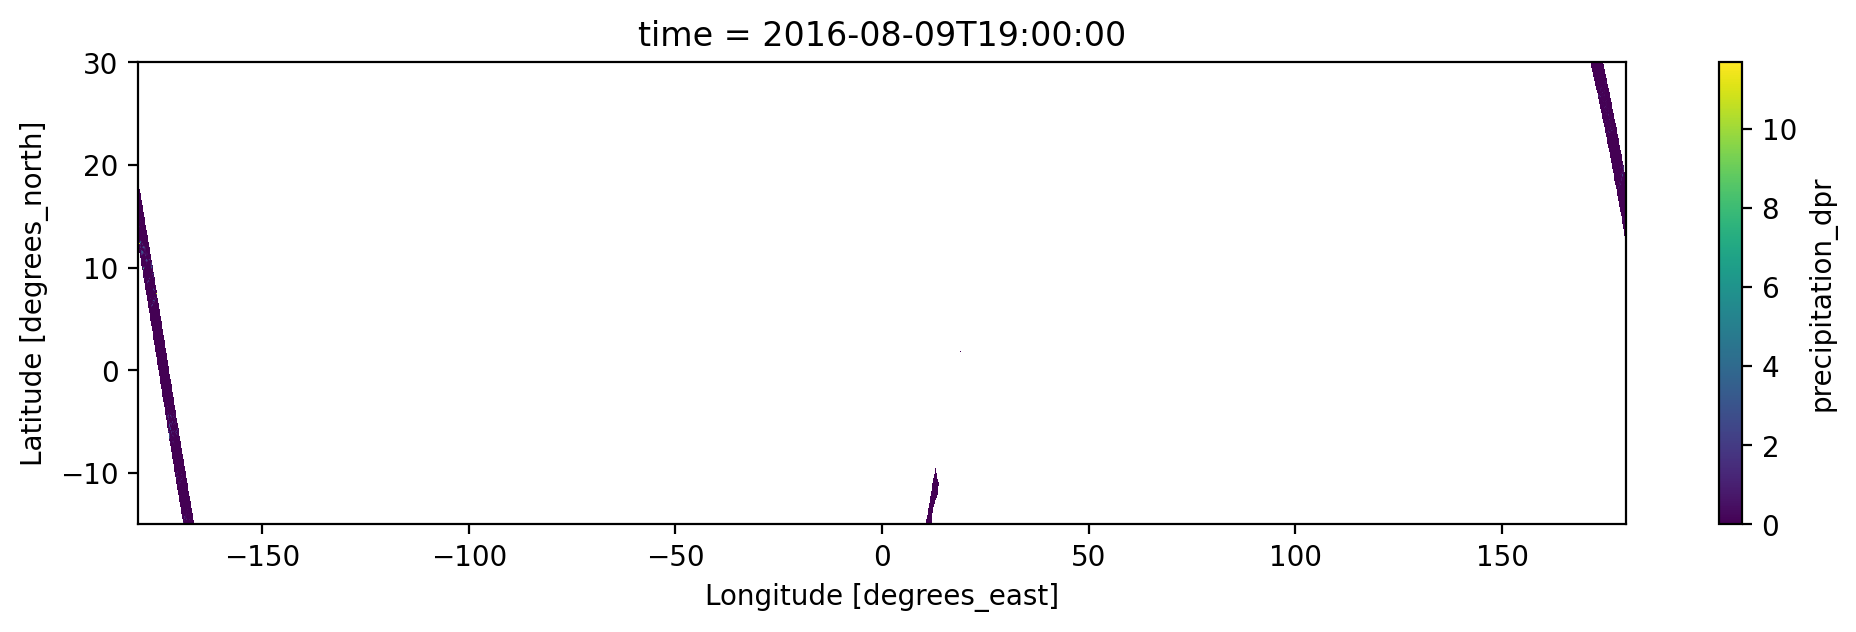

In [25]:
fig, ax = plt.subplots(1,1,figsize=(12,3), dpi=200)
# ds.precipitation.isel(time=100).where(ds.landseamask > 90).plot(ax=ax)
ds6.precipitation_dpr.isel(time=100).where(ds6.landseamask > 90).plot(ax=ax)

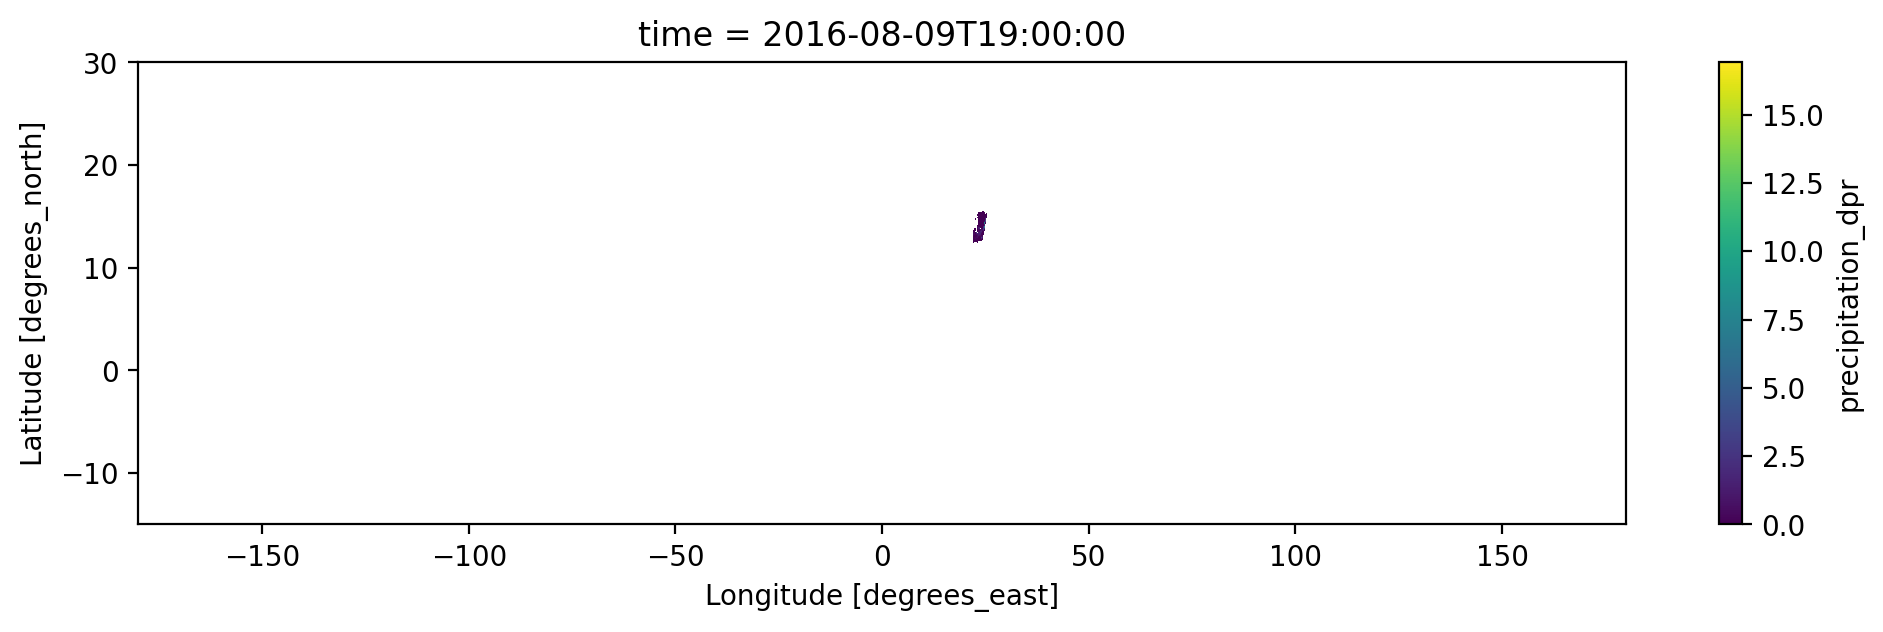

In [26]:
fig, ax = plt.subplots(1,1,figsize=(12,3), dpi=200)
# ds.precipitation.isel(time=100).where(ds.landseamask > 90).plot(ax=ax)
ds6.precipitation_dpr.isel(time=100).where(ds6.mcs_mask.isel(time=100) > 0).plot(ax=ax)

In [27]:
# Combine the DataSets, aligning them on the new time coordinates
ds7 = xr.merge([ds_i7_sub, dsm7_sub, ds_dpr_reindexed])
# Add landseamask to the DataSet
ds7['landseamask'] = ds_lm.landseamask
ds7

<xarray.Dataset>
Dimensions:                 (time: 395, lat: 450, lon: 3600)
Coordinates:
  * time                    (time) datetime64[ns] 2016-08-03 ... 2016-08-31T2...
  * lon                     (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
  * lat                     (lat) float64 -14.95 -14.85 -14.75 ... 29.85 29.95
Data variables:
    Tb                      (time, lat, lon) float32 ...
    precipitation           (time, lat, lon) float32 ...
    cloud_mask              (time, lat, lon) int64 ...
    mcs_mask_no_mergesplit  (time, lat, lon) int64 ...
    mcs_mask                (time, lat, lon) int64 ...
    longitude               (lat, lon) float64 ...
    latitude                (lat, lon) float64 ...
    precipitation_dpr       (time, lat, lon) float32 dask.array<chunksize=(1, 450, 3600), meta=np.ndarray>
    landseamask             (lat, lon) float32 ...
Attributes:
    Title:       Summer OBSv7 OLR & precipitation
    phase:       Summer
    source:      OBSv7
    Created_on:  Thu Mar 21 09:29:16 2024

In [28]:
# ds.precipitation_dpr.isel(time=1).plot(vmin=0, vmax=20)

In [29]:
# ds.precipitation.where(ds.precipitation_dpr >= 0).isel(time=1).plot(vmin=0, vmax=20)

In [30]:
# ds7.precipitation.where(ds7.precipitation_dpr >= 0).isel(time=1).plot(vmin=0, vmax=20)

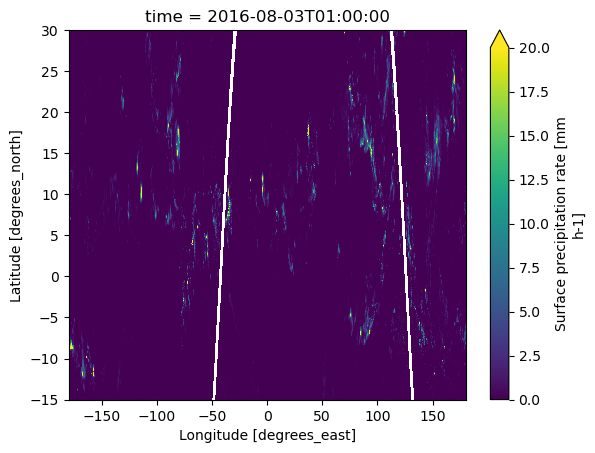

In [31]:
ds6.precipitation.where(np.isnan(ds6.precipitation_dpr)).isel(time=1).plot(vmin=0, vmax=20)

In [32]:
# Separate DPR ocean vs. land precipitation
pcp_dpr_o = ds6.precipitation_dpr.where(ds6.landseamask >= ocean_thresh)
pcp_dpr_l = ds6.precipitation_dpr.where(ds6.landseamask <= land_thresh)

# Separate DPR ocean vs. land MCS precipitation
mcspcp_dpr_o = ds6.precipitation_dpr.where((ds6.landseamask >= ocean_thresh) & (ds6.mcs_mask > 0))
mcspcp_dpr_l = ds6.precipitation_dpr.where((ds6.landseamask <= land_thresh) & (ds6.mcs_mask > 0))

In [33]:
# Separate IMERG data to within and outside of DPR swaths
pcp_imerg6_in = ds6.precipitation.where(ds6.precipitation_dpr >= 0)
pcp_imerg6_out = ds6.precipitation.where(np.isnan(ds6.precipitation_dpr))

# Separate ocean vs. land precipitation
# Ocean
pcp_imerg6_o_in = ds6.precipitation.where((ds6.precipitation_dpr >= 0) & (ds6.landseamask >= ocean_thresh))
pcp_imerg6_o_out = ds6.precipitation.where((np.isnan(ds6.precipitation_dpr)) & (ds6.landseamask >= ocean_thresh))

# Land
pcp_imerg6_l_in = ds6.precipitation.where((ds6.precipitation_dpr >= 0) & (ds6.landseamask <= land_thresh))
pcp_imerg6_l_out = ds6.precipitation.where((np.isnan(ds6.precipitation_dpr)) & (ds6.landseamask <= land_thresh))

# Separate ocean vs. land MCS precipitation
mcspcp_imerg6 = ds6.precipitation.where(ds6.mcs_mask > 0)
mcspcp_imerg6_o = ds6.precipitation.where((ds6.landseamask >= ocean_thresh) & (ds6.mcs_mask > 0))
mcspcp_imerg6_l = ds6.precipitation.where((ds6.landseamask <= land_thresh) & (ds6.mcs_mask > 0))

In [35]:
# Separate IMERG data to within and outside of DPR swaths
pcp_imerg7_in = ds7.precipitation.where(ds7.precipitation_dpr >= 0)
pcp_imerg7_out = ds7.precipitation.where(np.isnan(ds7.precipitation_dpr))

# Separate ocean vs. land precipitation
# Ocean
pcp_imerg7_o_in = ds7.precipitation.where((ds7.precipitation_dpr >= 0) & (ds7.landseamask >= ocean_thresh))
pcp_imerg7_o_out = ds7.precipitation.where((np.isnan(ds7.precipitation_dpr)) & (ds7.landseamask >= ocean_thresh))

# Land
pcp_imerg7_l_in = ds7.precipitation.where((ds7.precipitation_dpr >= 0) & (ds7.landseamask <= land_thresh))
pcp_imerg7_l_out = ds7.precipitation.where((np.isnan(ds7.precipitation_dpr)) & (ds7.landseamask <= land_thresh))

# Separate ocean vs. land MCS precipitation
mcspcp_imerg7 = ds7.precipitation.where(ds7.mcs_mask > 0)
mcspcp_imerg7_o = ds7.precipitation.where((ds7.landseamask >= ocean_thresh) & (ds7.mcs_mask > 0))
mcspcp_imerg7_l = ds7.precipitation.where((ds7.landseamask <= land_thresh) & (ds7.mcs_mask > 0))

## Calculate histogram

In [36]:
# Set up rain rate bins
bins_pcp = np.arange(1, 301, 1)
# bins_pcp = np.arange(1, 301, 2)
pcp_range = (np.min(bins_pcp), np.max(bins_pcp))

# Rain rate bin center values
# bins_pcp_c = 0.5 * (bins_pcp[1:] - bins_pcp[:-1]) + bins_pcp[:-1]
bins_pcp_c = bins_pcp[:-1]

In [37]:
pcp_dpr_hist, bins = np.histogram(ds6.precipitation_dpr, bins=bins_pcp, range=pcp_range, density=False)

pcp_dpr_o_hist, bins = np.histogram(pcp_dpr_o, bins=bins_pcp, range=pcp_range, density=False)
pcp_dpr_l_hist, bins = np.histogram(pcp_dpr_l, bins=bins_pcp, range=pcp_range, density=False)

mcspcp_dpr_o_hist, bins = np.histogram(mcspcp_dpr_o, bins=bins_pcp, range=pcp_range, density=False)
mcspcp_dpr_l_hist, bins = np.histogram(mcspcp_dpr_l, bins=bins_pcp, range=pcp_range, density=False)

In [38]:
pcp_imerg6_in_hist, bins = np.histogram(pcp_imerg6_in, bins=bins_pcp, range=pcp_range, density=False)
pcp_imerg6_out_hist, bins = np.histogram(pcp_imerg6_out, bins=bins_pcp, range=pcp_range, density=False)

pcp_imerg6_o_in_hist, bins = np.histogram(pcp_imerg6_o_in, bins=bins_pcp, range=pcp_range, density=False)
pcp_imerg6_o_out_hist, bins = np.histogram(pcp_imerg6_o_out, bins=bins_pcp, range=pcp_range, density=False)

pcp_imerg6_l_in_hist, bins = np.histogram(pcp_imerg6_l_in, bins=bins_pcp, range=pcp_range, density=False)
pcp_imerg6_l_out_hist, bins = np.histogram(pcp_imerg6_l_out, bins=bins_pcp, range=pcp_range, density=False)

mcspcp_imerg6_o_hist, bins = np.histogram(mcspcp_imerg6_o, bins=bins_pcp, range=pcp_range, density=False)
mcspcp_imerg6_l_hist, bins = np.histogram(mcspcp_imerg6_l, bins=bins_pcp, range=pcp_range, density=False)

In [39]:
pcp_imerg7_in_hist, bins = np.histogram(pcp_imerg7_in, bins=bins_pcp, range=pcp_range, density=False)
pcp_imerg7_out_hist, bins = np.histogram(pcp_imerg7_out, bins=bins_pcp, range=pcp_range, density=False)

pcp_imerg7_o_in_hist, bins = np.histogram(pcp_imerg7_o_in, bins=bins_pcp, range=pcp_range, density=False)
pcp_imerg7_o_out_hist, bins = np.histogram(pcp_imerg7_o_out, bins=bins_pcp, range=pcp_range, density=False)

pcp_imerg7_l_in_hist, bins = np.histogram(pcp_imerg7_l_in, bins=bins_pcp, range=pcp_range, density=False)
pcp_imerg7_l_out_hist, bins = np.histogram(pcp_imerg7_l_out, bins=bins_pcp, range=pcp_range, density=False)

mcspcp_imerg7_o_hist, bins = np.histogram(mcspcp_imerg7_o, bins=bins_pcp, range=pcp_range, density=False)
mcspcp_imerg7_l_hist, bins = np.histogram(mcspcp_imerg7_l, bins=bins_pcp, range=pcp_range, density=False)

## Calculate PDF

In [40]:
pcp_dpr_pdf = pcp_dpr_hist / np.nansum(pcp_dpr_hist)

pcp_dpr_o_pdf = pcp_dpr_o_hist / np.nansum(pcp_dpr_o_hist)
pcp_dpr_l_pdf = pcp_dpr_l_hist / np.nansum(pcp_dpr_l_hist)

mcspcp_dpr_o_pdf = mcspcp_dpr_o_hist / np.nansum(mcspcp_dpr_o_hist)
mcspcp_dpr_l_pdf = mcspcp_dpr_l_hist / np.nansum(mcspcp_dpr_l_hist)

In [41]:
pcp_imerg6_in_pdf = pcp_imerg6_in_hist / np.nansum(pcp_imerg6_in_hist)
pcp_imerg6_out_pdf = pcp_imerg6_out_hist / np.nansum(pcp_imerg6_out_hist)

pcp_imerg6_o_in_pdf = pcp_imerg6_o_in_hist / np.nansum(pcp_imerg6_o_in_hist)
pcp_imerg6_o_out_pdf = pcp_imerg6_o_out_hist / np.nansum(pcp_imerg6_o_out_hist)

pcp_imerg6_l_in_pdf = pcp_imerg6_l_in_hist / np.nansum(pcp_imerg6_l_in_hist)
pcp_imerg6_l_out_pdf = pcp_imerg6_l_out_hist / np.nansum(pcp_imerg6_l_out_hist)

mcspcp_imerg6_o_pdf = mcspcp_imerg6_o_hist / np.nansum(mcspcp_imerg6_o_hist)
mcspcp_imerg6_l_pdf = mcspcp_imerg6_l_hist / np.nansum(mcspcp_imerg6_l_hist)

In [42]:
pcp_imerg7_in_pdf = pcp_imerg7_in_hist / np.nansum(pcp_imerg7_in_hist)
pcp_imerg7_out_pdf = pcp_imerg7_out_hist / np.nansum(pcp_imerg7_out_hist)

pcp_imerg7_o_in_pdf = pcp_imerg7_o_in_hist / np.nansum(pcp_imerg7_o_in_hist)
pcp_imerg7_o_out_pdf = pcp_imerg7_o_out_hist / np.nansum(pcp_imerg7_o_out_hist)

pcp_imerg7_l_in_pdf = pcp_imerg7_l_in_hist / np.nansum(pcp_imerg7_l_in_hist)
pcp_imerg7_l_out_pdf = pcp_imerg7_l_out_hist / np.nansum(pcp_imerg7_l_out_hist)

mcspcp_imerg7_o_pdf = mcspcp_imerg7_o_hist / np.nansum(mcspcp_imerg7_o_hist)
mcspcp_imerg7_l_pdf = mcspcp_imerg7_l_hist / np.nansum(mcspcp_imerg7_l_hist)

In [43]:
# Multiply histogram by bin value to get total amount of rain for each bin
imerg6_amt_in_hist = pcp_imerg6_in_hist * bins_pcp_c
imerg7_amt_in_hist = pcp_imerg7_in_hist * bins_pcp_c
imerg6_amt_out_hist = pcp_imerg6_out_hist * bins_pcp_c
imerg7_amt_out_hist = pcp_imerg7_out_hist * bins_pcp_c
dpr_amt_hist = pcp_dpr_hist * bins_pcp_c

# Get fractional contribution by dividing the sum of all rain bins
imerg6_amt_in_frac = imerg6_amt_in_hist / imerg6_amt_in_hist.sum()
imerg7_amt_in_frac = imerg7_amt_in_hist / imerg7_amt_in_hist.sum()
imerg6_amt_out_frac = imerg6_amt_out_hist / imerg6_amt_out_hist.sum()
imerg7_amt_out_frac = imerg7_amt_out_hist / imerg7_amt_out_hist.sum()
dpr_amt_frac = dpr_amt_hist / dpr_amt_hist.sum()

In [44]:
# Multiply histogram by bin value to get total amount of rain for each bin
dpr_mcsamt_o_hist = mcspcp_dpr_o_hist * bins_pcp_c
dpr_mcsamt_l_hist = mcspcp_dpr_l_hist * bins_pcp_c
imerg6_mcsamt_o_hist = mcspcp_imerg6_o_hist * bins_pcp_c
imerg6_mcsamt_l_hist = mcspcp_imerg6_l_hist * bins_pcp_c
imerg7_mcsamt_o_hist = mcspcp_imerg7_o_hist * bins_pcp_c
imerg7_mcsamt_l_hist = mcspcp_imerg7_l_hist * bins_pcp_c

# Get fractional contribution by dividing the sum of all rain bins
dpr_mcsamt_frac_o = dpr_mcsamt_o_hist / dpr_mcsamt_o_hist.sum()
dpr_mcsamt_frac_l = dpr_mcsamt_l_hist / dpr_mcsamt_l_hist.sum()
imerg6_mcsamt_frac_o = imerg6_mcsamt_o_hist / imerg6_mcsamt_o_hist.sum()
imerg6_mcsamt_frac_l = imerg6_mcsamt_l_hist / imerg6_mcsamt_l_hist.sum()
imerg7_mcsamt_frac_o = imerg7_mcsamt_o_hist / imerg7_mcsamt_o_hist.sum()
imerg7_mcsamt_frac_l = imerg7_mcsamt_l_hist / imerg7_mcsamt_l_hist.sum()

In [45]:
if PHASE == 'Summer':
    panel_numbers = ['(a)','(c)']
elif PHASE == 'Winter':
    panel_numbers = ['(b)','(d)']
panel_numbers

['(a)', '(c)']

In [46]:
# Make lat bound formats for plotting
lat_min = f'{-1*lat_bounds[0]}°S' if lat_bounds[0] < 0 else f'{lat_bounds[0]}°N'
lat_max = f'{-1*lat_bounds[1]}°S' if lat_bounds[1] < 0 else f'{lat_bounds[1]}°N'
f'({PHASE}, {lat_min} - {lat_max})'

'(Summer, 15°S - 30°N)'

# Plot rain rate PDF

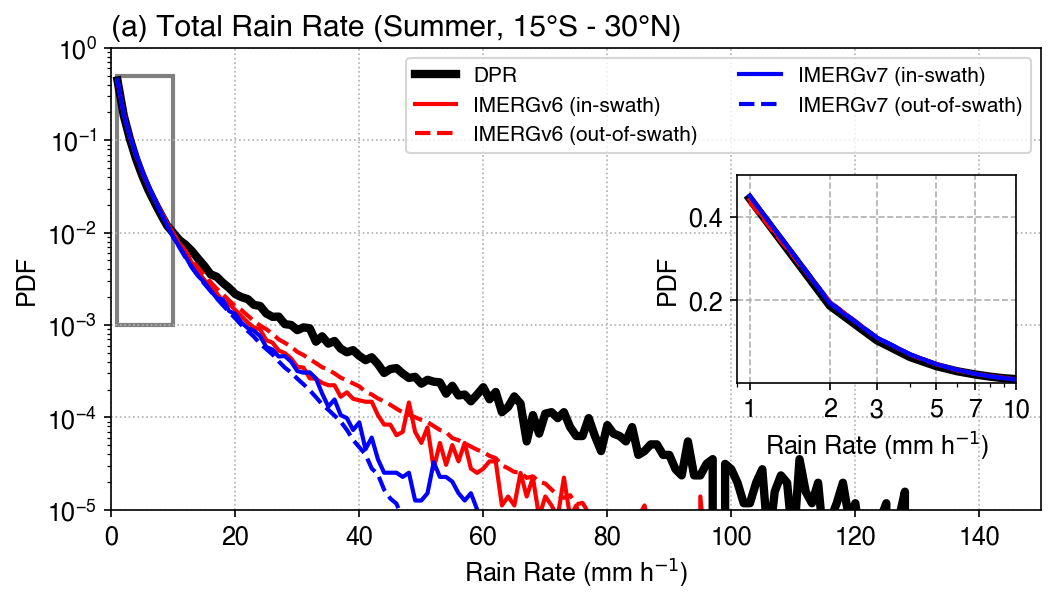

In [47]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Helvetica'
lw = 2
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = 'PDF'

fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi=150)
ax.plot(bins_pcp_c, pcp_dpr_pdf, color='k', lw=lw*2, label='DPR')
ax.plot(bins_pcp_c, pcp_imerg6_in_pdf, color='r', lw=lw, label='IMERGv6 (in-swath)')
ax.plot(bins_pcp_c, pcp_imerg6_out_pdf, color='r', lw=lw, ls='--', label='IMERGv6 (out-of-swath)')
ax.plot(bins_pcp_c, pcp_imerg7_in_pdf, color='b', lw=lw, label='IMERGv7 (in-swath)')
ax.plot(bins_pcp_c, pcp_imerg7_out_pdf, color='b', ls='--', lw=lw, label='IMERGv7 (out-of-swath)')
ax.set_yscale('log')
ax.set_xlim(0, 150)
ax.set_ylim(1e-5, 1)
ax.grid(ls=':')
ax.legend(ncol=2, fontsize=10)
ax.set_xlabel(xlabels)
ax.set_ylabel(ylabels)
ax.set_title(f'{panel_numbers[0]} Total Rain Rate ({PHASE}, {lat_min} - {lat_max})', loc='left')

# Inset plot
x_sub = (0.9, 10)
y_sub = (1e-3, 0.5)
yscale_sub = 'linear'
xscale_sub = 'log'
xticks_sub = [1, 2, 3, 5, 7, 10,]
box_color = 'gray'
line_width = 2
width = '30%'
height = '45%'
loc = 'center right'
borderpad = 1
# Create the inset plot
axins = inset_axes(ax, width=width, height=height, loc=loc, borderpad=borderpad)
axins.plot(bins_pcp_c, pcp_dpr_pdf, color='k', lw=lw*2, label='DPR')
axins.plot(bins_pcp_c, pcp_imerg6_in_pdf, color='r', lw=lw, label='IMERGv6 (in-swath)')
axins.plot(bins_pcp_c, pcp_imerg6_out_pdf, color='r', lw=lw, ls='--', label='IMERGv6 (out-of-swath)')
axins.plot(bins_pcp_c, pcp_imerg7_in_pdf, color='b', lw=lw, label='IMERGv7 (in-swath)')
axins.plot(bins_pcp_c, pcp_imerg7_out_pdf, color='b', ls='--', lw=lw, label='IMERGv7 (out-of-swath)')
axins.set_xlim(x_sub[0], x_sub[1])
axins.set_ylim(y_sub[0], y_sub[1])
axins.set_xscale(xscale_sub)
axins.set_yscale(yscale_sub)
axins.set_xlabel(xlabels)
axins.set_ylabel(ylabels)
axins.set_xticks(xticks_sub)
axins.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
axins.grid(which='major', ls='--')
# Add rectangle indicating the zoomed region in the main plot
rect = plt.Rectangle((x_sub[0], y_sub[0]), x_sub[1] - x_sub[0], y_sub[1] - y_sub[0], linewidth=line_width, edgecolor=box_color, facecolor='none')
ax.add_patch(rect)

figname = f'{figdir}global_total_pcp_pdf_dpr_imerg.png'
fig.savefig(figname, bbox_inches='tight', dpi=300, facecolor='w')

/tmp/ipykernel_841371/2933600897.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


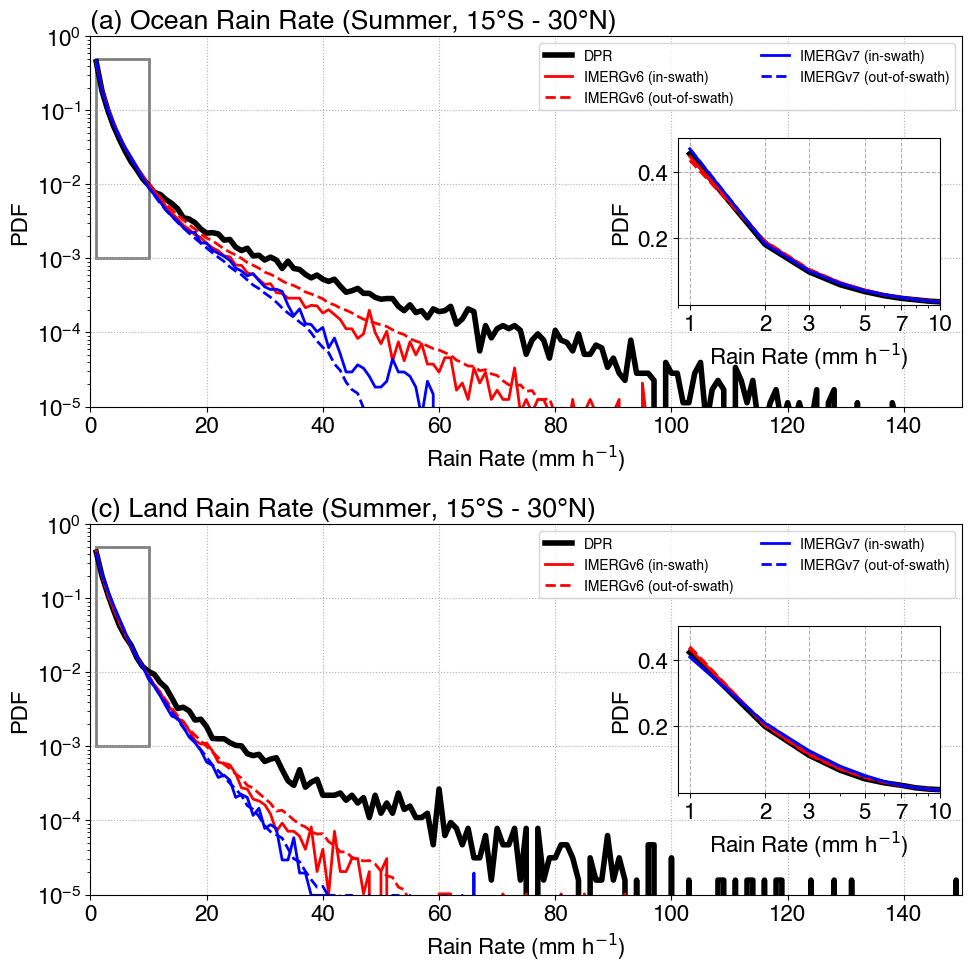

In [48]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
lw = 2
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = 'PDF'
x_sub = (0.9, 10)
y_sub = (1e-3, 0.5)
yscale_sub = 'linear'
xscale_sub = 'log'
xticks_sub = [1, 2, 3, 5, 7, 10,]
box_color = 'gray'
line_width = 2
width = '30%'
height = '45%'
loc = 'center right'
borderpad = 1

fig, axes = plt.subplots(2, 1, figsize=(10,10), dpi=100)
ax = axes[0]
ax.plot(bins_pcp_c, pcp_dpr_o_pdf, color='k', lw=lw*2, label='DPR')
ax.plot(bins_pcp_c, pcp_imerg6_o_in_pdf, color='r', lw=lw, label='IMERGv6 (in-swath)')
ax.plot(bins_pcp_c, pcp_imerg6_o_out_pdf, color='r', lw=lw, ls='--', label='IMERGv6 (out-of-swath)')
ax.plot(bins_pcp_c, pcp_imerg7_o_in_pdf, color='b', lw=lw, label='IMERGv7 (in-swath)')
ax.plot(bins_pcp_c, pcp_imerg7_o_out_pdf, color='b', ls='--', lw=lw, label='IMERGv7 (out-of-swath)')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0, 150)
ax.set_ylim(1e-5, 1)
# ax.set_xticks(xticks)
# ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.grid(ls=':')
ax.legend(ncol=2, fontsize=10)
ax.set_xlabel(xlabels)
ax.set_ylabel(ylabels)
ax.set_title(f'{panel_numbers[0]} Ocean Rain Rate ({PHASE}, {lat_min} - {lat_max})', loc='left')

# Create the inset plot
axins = inset_axes(ax, width=width, height=height, loc=loc, borderpad=borderpad)
axins.plot(bins_pcp_c, pcp_dpr_o_pdf, color='k', lw=lw*2, label='DPR')
axins.plot(bins_pcp_c, pcp_imerg6_o_in_pdf, color='r', lw=lw, label='IMERGv6 (in-swath)')
axins.plot(bins_pcp_c, pcp_imerg6_o_out_pdf, color='r', lw=lw, ls='--', label='IMERGv6 (out-of-swath)')
axins.plot(bins_pcp_c, pcp_imerg7_o_in_pdf, color='b', lw=lw, label='IMERGv7 (in-swath)')
axins.plot(bins_pcp_c, pcp_imerg7_o_out_pdf, color='b', ls='--', lw=lw, label='IMERGv7 (out-of-swath)')
axins.set_xlim(x_sub[0], x_sub[1])
axins.set_ylim(y_sub[0], y_sub[1])
axins.set_xscale(xscale_sub)
axins.set_yscale(yscale_sub)
axins.set_xlabel(xlabels)
axins.set_ylabel(ylabels)
axins.set_xticks(xticks_sub)
axins.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
axins.grid(which='major', ls='--')
# Add rectangle indicating the zoomed region in the main plot
rect = plt.Rectangle((x_sub[0], y_sub[0]), x_sub[1] - x_sub[0], y_sub[1] - y_sub[0], linewidth=line_width, edgecolor=box_color, facecolor='none')
ax.add_patch(rect)


#------------------------------------------------
ax = axes[1]
ax.plot(bins_pcp_c, pcp_dpr_l_pdf, color='k', lw=lw*2, label='DPR')
ax.plot(bins_pcp_c, pcp_imerg6_l_in_pdf, color='r', lw=lw, label='IMERGv6 (in-swath)')
ax.plot(bins_pcp_c, pcp_imerg6_l_out_pdf, color='r', lw=lw, ls='--', label='IMERGv6 (out-of-swath)')
ax.plot(bins_pcp_c, pcp_imerg7_l_in_pdf, color='b', lw=lw, label='IMERGv7 (in-swath)')
ax.plot(bins_pcp_c, pcp_imerg7_l_out_pdf, color='b', ls='--', lw=lw, label='IMERGv7 (out-of-swath)')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0, 150)
ax.set_ylim(1e-5, 1)
# ax.set_xticks(xticks)
# ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.grid(ls=':')
ax.legend(ncol=2, fontsize=10)
ax.set_xlabel(xlabels)
ax.set_ylabel(ylabels)
ax.set_title(f'{panel_numbers[1]} Land Rain Rate ({PHASE}, {lat_min} - {lat_max})', loc='left')

# Create the inset plot
axins = inset_axes(ax, width=width, height=height, loc=loc, borderpad=borderpad)
axins.plot(bins_pcp_c, pcp_dpr_l_pdf, color='k', lw=lw*2, label='DPR')
axins.plot(bins_pcp_c, pcp_imerg6_l_in_pdf, color='r', lw=lw, label='IMERGv6 (in-swath)')
axins.plot(bins_pcp_c, pcp_imerg6_l_out_pdf, color='r', lw=lw, ls='--', label='IMERGv6 (out-of-swath)')
axins.plot(bins_pcp_c, pcp_imerg7_l_in_pdf, color='b', lw=lw, label='IMERGv7 (in-swath)')
axins.plot(bins_pcp_c, pcp_imerg7_l_out_pdf, color='b', ls='--', lw=lw, label='IMERGv7 (out-of-swath)')
axins.set_xlim(x_sub[0], x_sub[1])
axins.set_ylim(y_sub[0], y_sub[1])
axins.set_xscale(xscale_sub)
axins.set_yscale(yscale_sub)
axins.set_xlabel(xlabels)
axins.set_ylabel(ylabels)
axins.set_xticks(xticks_sub)
axins.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
axins.grid(which='major', ls='--')
# Add rectangle indicating the zoomed region in the main plot
rect = plt.Rectangle((x_sub[0], y_sub[0]), x_sub[1] - x_sub[0], y_sub[1] - y_sub[0], linewidth=line_width, edgecolor=box_color, facecolor='none')
ax.add_patch(rect)

fig.tight_layout()
figname = f'{figdir}global_total_pcp_fractional_pdf_dpr_imerg6_ocean_land.png'
# fig.savefig(figname, bbox_inches='tight', dpi=300, facecolor='w')

/tmp/ipykernel_841371/3314634464.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


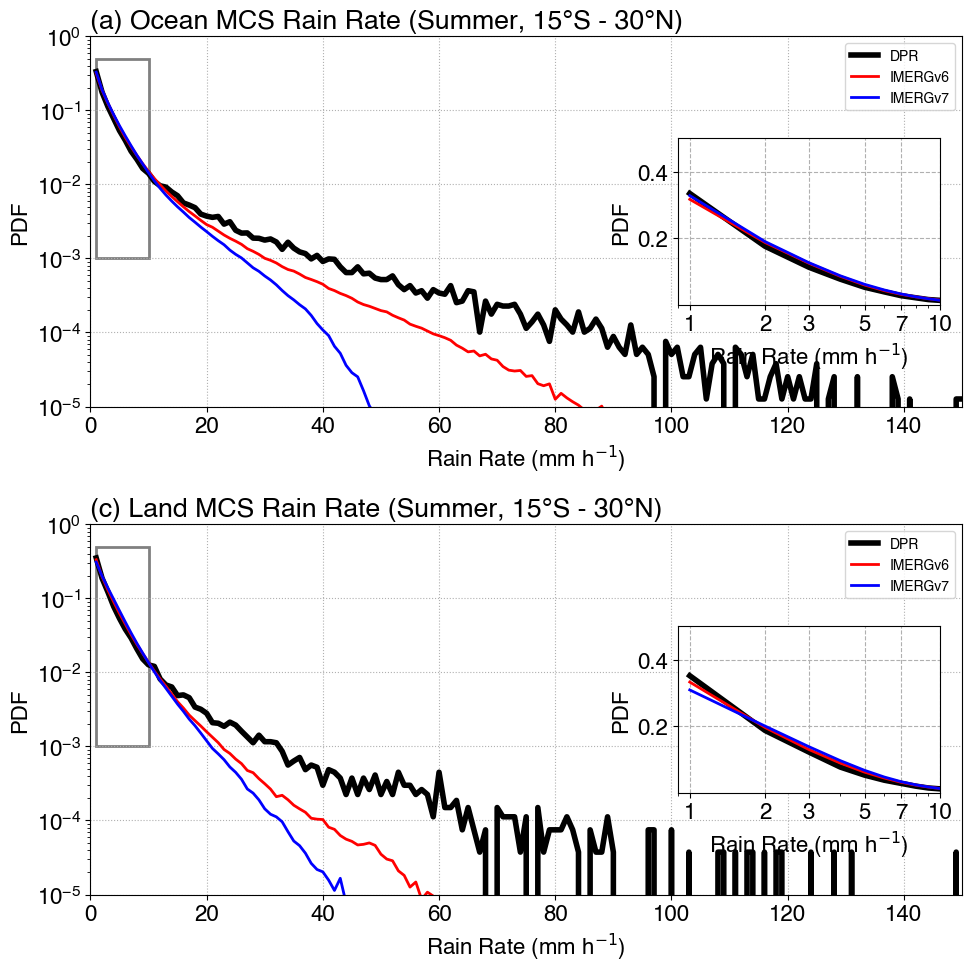

In [49]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
lw = 2
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = 'PDF'
x_sub = (0.9, 10)
y_sub = (1e-3, 0.5)
yscale_sub = 'linear'
xscale_sub = 'log'
xticks_sub = [1, 2, 3, 5, 7, 10,]
box_color = 'gray'
line_width = 2
width = '30%'
height = '45%'
loc = 'center right'
borderpad = 1

fig, axes = plt.subplots(2, 1, figsize=(10,10), dpi=100)
ax = axes[0]
ax.plot(bins_pcp_c, mcspcp_dpr_o_pdf, color='k', lw=lw*2, label='DPR')
ax.plot(bins_pcp_c, mcspcp_imerg6_o_pdf, color='r', lw=lw, label='IMERGv6')
ax.plot(bins_pcp_c, mcspcp_imerg7_o_pdf, color='b', lw=lw, label='IMERGv7')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0, 150)
ax.set_ylim(1e-5, 1)
# ax.set_xticks(xticks)
# ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.grid(ls=':')
ax.legend(ncol=1, fontsize=10)
ax.set_xlabel(xlabels)
ax.set_ylabel(ylabels)
ax.set_title(f'{panel_numbers[0]} Ocean MCS Rain Rate ({PHASE}, {lat_min} - {lat_max})', loc='left')

# Create the inset plot
axins = inset_axes(ax, width=width, height=height, loc=loc, borderpad=borderpad)
axins.plot(bins_pcp_c, mcspcp_dpr_o_pdf, color='k', lw=lw*2, label='DPR')
axins.plot(bins_pcp_c, mcspcp_imerg6_o_pdf, color='r', lw=lw, label='IMERGv6')
axins.plot(bins_pcp_c, mcspcp_imerg7_o_pdf, color='b', lw=lw, label='IMERGv7')
axins.set_xlim(x_sub[0], x_sub[1])
axins.set_ylim(y_sub[0], y_sub[1])
axins.set_xscale(xscale_sub)
axins.set_yscale(yscale_sub)
axins.set_xlabel(xlabels)
axins.set_ylabel(ylabels)
axins.set_xticks(xticks_sub)
axins.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
axins.grid(which='major', ls='--')
# Add rectangle indicating the zoomed region in the main plot
rect = plt.Rectangle((x_sub[0], y_sub[0]), x_sub[1] - x_sub[0], y_sub[1] - y_sub[0], linewidth=line_width, edgecolor=box_color, facecolor='none')
ax.add_patch(rect)


#------------------------------------------------
ax = axes[1]
ax.plot(bins_pcp_c, mcspcp_dpr_l_pdf, color='k', lw=lw*2, label='DPR')
ax.plot(bins_pcp_c, mcspcp_imerg6_l_pdf, color='r', lw=lw, label='IMERGv6')
ax.plot(bins_pcp_c, mcspcp_imerg7_l_pdf, color='b', lw=lw, label='IMERGv7')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0, 150)
ax.set_ylim(1e-5, 1)
# ax.set_xticks(xticks)
# ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.grid(ls=':')
ax.legend(ncol=1, fontsize=10)
ax.set_xlabel(xlabels)
ax.set_ylabel(ylabels)
ax.set_title(f'{panel_numbers[1]} Land MCS Rain Rate ({PHASE}, {lat_min} - {lat_max})', loc='left')

# Create the inset plot
axins = inset_axes(ax, width=width, height=height, loc=loc, borderpad=borderpad)
axins.plot(bins_pcp_c, mcspcp_dpr_l_pdf, color='k', lw=lw*2, label='DPR')
axins.plot(bins_pcp_c, mcspcp_imerg6_l_pdf, color='r', lw=lw, label='IMERGv6')
axins.plot(bins_pcp_c, mcspcp_imerg7_l_pdf, color='b', lw=lw, label='IMERGv7')
axins.set_xlim(x_sub[0], x_sub[1])
axins.set_ylim(y_sub[0], y_sub[1])
axins.set_xscale(xscale_sub)
axins.set_yscale(yscale_sub)
axins.set_xlabel(xlabels)
axins.set_ylabel(ylabels)
axins.set_xticks(xticks_sub)
axins.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
axins.grid(which='major', ls='--')
# Add rectangle indicating the zoomed region in the main plot
rect = plt.Rectangle((x_sub[0], y_sub[0]), x_sub[1] - x_sub[0], y_sub[1] - y_sub[0], linewidth=line_width, edgecolor=box_color, facecolor='none')
ax.add_patch(rect)

fig.tight_layout()
figname = f'{figdir}global_mcs_pcp_pdf_dpr_imerg_ocean_land.png'
# fig.savefig(figname, bbox_inches='tight', dpi=300, facecolor='w')

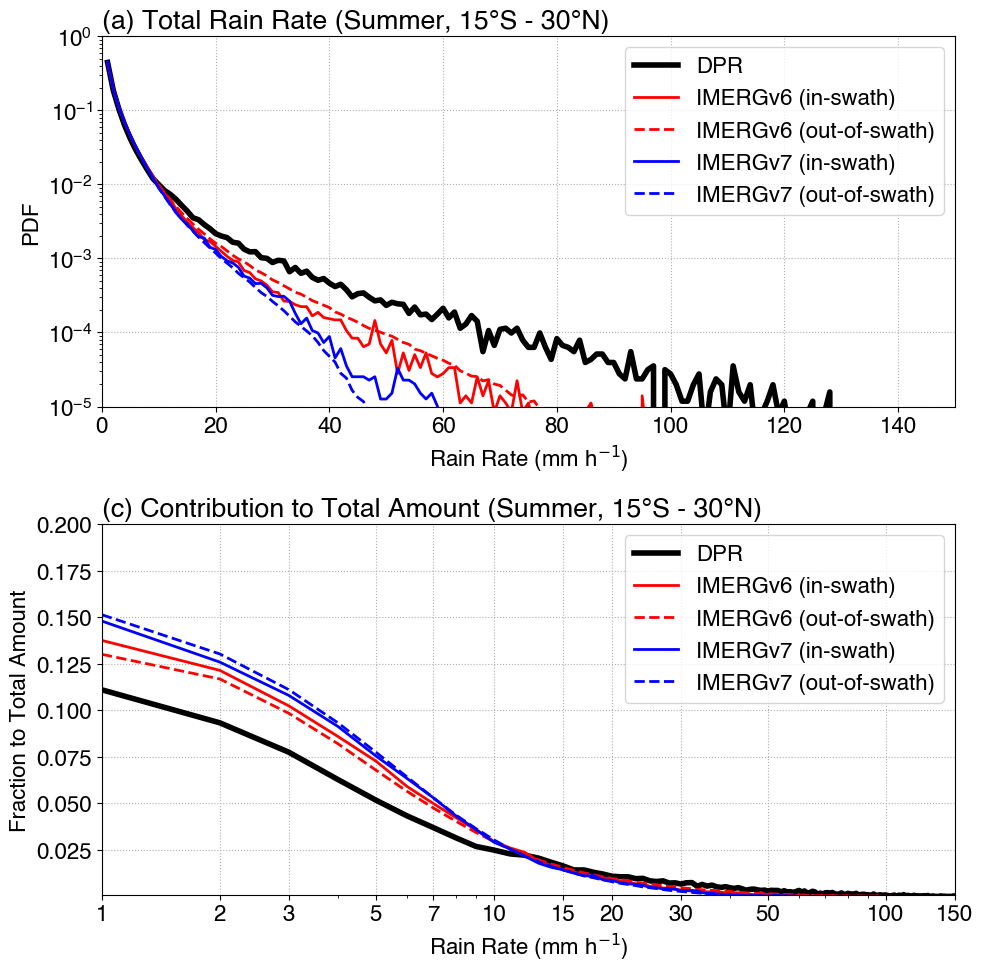

In [50]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
lw = 2
xticks = [1,2,3,5,7,10,15,20,30,50,100,150]

fig, axes = plt.subplots(2, 1, figsize=(10,10), dpi=100)
ax = axes[0]
ax.plot(bins_pcp_c, pcp_dpr_pdf, color='k', lw=lw*2, label='DPR')
ax.plot(bins_pcp_c, pcp_imerg6_in_pdf, color='r', lw=lw, label='IMERGv6 (in-swath)')
ax.plot(bins_pcp_c, pcp_imerg6_out_pdf, color='r', lw=lw, ls='--', label='IMERGv6 (out-of-swath)')
ax.plot(bins_pcp_c, pcp_imerg7_in_pdf, color='b', lw=lw, label='IMERGv7 (in-swath)')
ax.plot(bins_pcp_c, pcp_imerg7_out_pdf, color='b', ls='--', lw=lw, label='IMERGv7 (out-of-swath)')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0, 150)
ax.set_ylim(1e-5, 1)
# ax.set_xticks(xticks)
# ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.grid(ls=':')
ax.legend()
ax.set_xlabel('Rain Rate (mm h$^{-1}$)')
ax.set_ylabel('PDF')
ax.set_title(f'{panel_numbers[0]} Total Rain Rate ({PHASE}, {lat_min} - {lat_max})', loc='left')

ax = axes[1]
ax.plot(bins_pcp_c, dpr_amt_frac, color='k', lw=lw*2, label='DPR')
ax.plot(bins_pcp_c, imerg6_amt_in_frac, color='r', lw=lw, label='IMERGv6 (in-swath)')
ax.plot(bins_pcp_c, imerg6_amt_out_frac, color='r', lw=lw, ls='--', label='IMERGv6 (out-of-swath)')
ax.plot(bins_pcp_c, imerg7_amt_in_frac, color='b', lw=lw, label='IMERGv7 (in-swath)')
ax.plot(bins_pcp_c, imerg7_amt_out_frac, color='b', ls='--', lw=lw, label='IMERGv7 (out-of-swath)')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1, 150)
ax.set_ylim(1e-3, 0.2)
ax.set_xticks(xticks)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.grid(ls=':')
ax.legend()
ax.set_xlabel('Rain Rate (mm h$^{-1}$)')
ax.set_ylabel('Fraction to Total Amount')
ax.set_title(f'{panel_numbers[1]} Contribution to Total Amount ({PHASE}, {lat_min} - {lat_max})', loc='left')

fig.tight_layout()
figname = f'{figdir}global_total_pcp_fractional_pdf_dpr_imerg.png'
# fig.savefig(figname, bbox_inches='tight', dpi=300, facecolor='w')

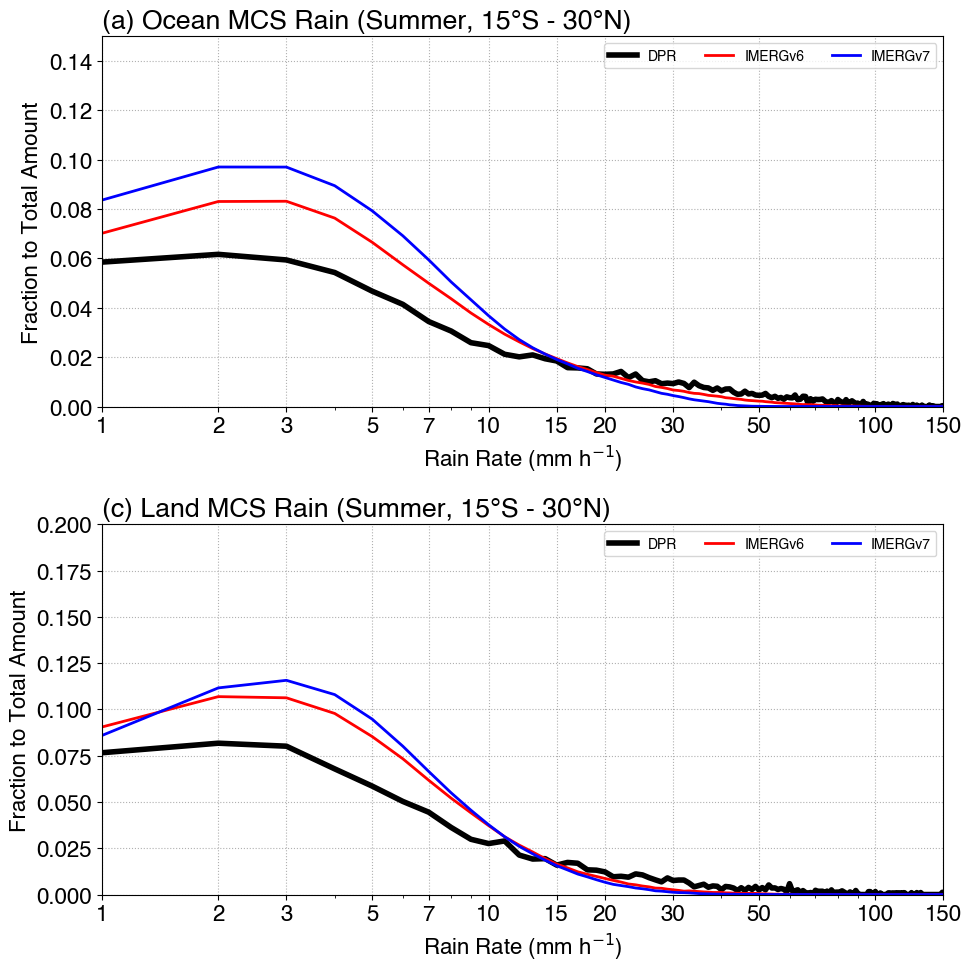

In [51]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
lw = 2
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = 'Fraction to Total Amount'
xticks = [1,2,3,5,7,10,15,20,30,50,100,150]
# x_sub = (0.9, 10)
x_sub = (10, 100)
y_sub = (1e-4, 0.05)
# y_sub = (1e-3, 0.5)
yscale_sub = 'log'
xscale_sub = 'log'
# xticks_sub = [1, 2, 3, 5, 7, 10,]
xticks_sub = [10,25,50,75,100]
box_color = 'gray'
line_width = 2
width = '30%'
height = '45%'
loc = 'center right'
borderpad = 1

fig, axes = plt.subplots(2, 1, figsize=(10,10), dpi=100)
ax = axes[0]
ax.plot(bins_pcp_c, dpr_mcsamt_frac_o, color='k', lw=lw*2, label='DPR')
ax.plot(bins_pcp_c, imerg6_mcsamt_frac_o, color='r', lw=lw, label='IMERGv6')
ax.plot(bins_pcp_c, imerg7_mcsamt_frac_o, color='b', lw=lw, label='IMERGv7')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1, 150)
ax.set_ylim(0, 0.15)
ax.set_xticks(xticks)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.grid(ls=':')
ax.legend(ncol=3, fontsize=10)
ax.set_xlabel(xlabels)
ax.set_ylabel(ylabels)
ax.set_title(f'{panel_numbers[0]} Ocean MCS Rain ({PHASE}, {lat_min} - {lat_max})', loc='left')

# # Create the inset plot
# axins = inset_axes(ax, width=width, height=height, loc=loc, borderpad=borderpad)
# axins.plot(bins_pcp_c, dpr_mcsamt_frac_o, color='k', lw=lw*2, label='DPR')
# axins.plot(bins_pcp_c, imerg6_mcsamt_frac_o, color='r', lw=lw, label='IMERGv6')
# axins.plot(bins_pcp_c, imerg7_mcsamt_frac_o, color='b', lw=lw, label='IMERGv7')
# axins.set_xlim(x_sub[0], x_sub[1])
# axins.set_ylim(y_sub[0], y_sub[1])
# axins.set_xscale(xscale_sub)
# axins.set_yscale(yscale_sub)
# axins.set_xlabel(xlabels)
# # axins.set_ylabel(ylabels)
# axins.set_xticks(xticks_sub)
# axins.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# axins.grid(which='major', ls='--')
# # Add rectangle indicating the zoomed region in the main plot
# rect = plt.Rectangle((x_sub[0], y_sub[0]), x_sub[1] - x_sub[0], y_sub[1] - y_sub[0], linewidth=line_width, edgecolor=box_color, facecolor='none')
# ax.add_patch(rect)


#------------------------------------------------
ax = axes[1]
ax.plot(bins_pcp_c, dpr_mcsamt_frac_l, color='k', lw=lw*2, label='DPR')
ax.plot(bins_pcp_c, imerg6_mcsamt_frac_l, color='r', lw=lw, label='IMERGv6')
ax.plot(bins_pcp_c, imerg7_mcsamt_frac_l, color='b', lw=lw, label='IMERGv7')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1, 150)
ax.set_ylim(0, 0.2)
ax.set_xticks(xticks)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.grid(ls=':')
ax.legend(ncol=3, fontsize=10)
ax.set_xlabel(xlabels)
ax.set_ylabel(ylabels)
ax.set_title(f'{panel_numbers[1]} Land MCS Rain ({PHASE}, {lat_min} - {lat_max})', loc='left')

# # Create the inset plot
# axins = inset_axes(ax, width=width, height=height, loc=loc, borderpad=borderpad)
# axins.plot(bins_pcp_c, dpr_mcsamt_frac_l, color='k', lw=lw*2, label='DPR')
# axins.plot(bins_pcp_c, imerg6_mcsamt_frac_l, color='r', lw=lw, label='IMERGv6')
# axins.plot(bins_pcp_c, imerg7_mcsamt_frac_l, color='b', lw=lw, label='IMERGv7')
# axins.set_xlim(x_sub[0], x_sub[1])
# axins.set_ylim(y_sub[0], y_sub[1])
# axins.set_xscale(xscale_sub)
# axins.set_yscale(yscale_sub)
# axins.set_xlabel(xlabels)
# # axins.set_ylabel(ylabels)
# axins.set_xticks(xticks_sub)
# axins.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# axins.grid(which='major', ls='--')
# # Add rectangle indicating the zoomed region in the main plot
# rect = plt.Rectangle((x_sub[0], y_sub[0]), x_sub[1] - x_sub[0], y_sub[1] - y_sub[0], linewidth=line_width, edgecolor=box_color, facecolor='none')
# ax.add_patch(rect)

fig.tight_layout()

In [52]:
#-------------------------------------------------------------------------
# Write output file
#-------------------------------------------------------------------------
# Define xarray output dataset
print('Writing output to netCDF file ...')
bins_pcp_attrs = {'units': 'mm h-1'}
tb_attrs = {'long_name': 'Tb histogram', 'units':'count'}
totpcp_dpr_attrs = {'long_name': 'DPR total precipitation histogram', 'units':'count'}
totpcp_dpr_o_attrs = {'long_name': 'DPR ocean precipitation histogram', 'units':'count'}
totpcp_dpr_l_attrs = {'long_name': 'DPR land precipitation histogram', 'units':'count'}
totpcp_imerg6_attrs = {'long_name': 'IMERGv6 total precipitation histogram', 'units':'count'}
totpcp_imerg6_o_attrs = {'long_name': 'IMERGv6 ocean precipitation histogram', 'units':'count'}
totpcp_imerg6_l_attrs = {'long_name': 'IMERGv6 land precipitation histogram', 'units':'count'}
totpcp_imerg7_attrs = {'long_name': 'IMERGv7 total precipitation histogram', 'units':'count'}
totpcp_imerg7_o_attrs = {'long_name': 'IMERGv7 ocean precipitation histogram', 'units':'count'}
totpcp_imerg7_l_attrs = {'long_name': 'IMERGv7 land precipitation histogram', 'units':'count'}

mcspcp_dpr_o_attrs = {'long_name': 'DPR ocean MCS precipitation histogram', 'units':'count'}
mcspcp_dpr_l_attrs = {'long_name': 'DPR land MCS precipitation histogram', 'units':'count'}

mcspcp_imerg6_o_attrs = {'long_name': 'DPR IMERGv6 ocean MCS precipitation histogram', 'units':'count'}
mcspcp_imerg6_l_attrs = {'long_name': 'DPR IMERGv6 land MCS precipitation histogram', 'units':'count'}

mcspcp_imerg7_o_attrs = {'long_name': 'DPR IMERGv7 ocean MCS precipitation histogram', 'units':'count'}
mcspcp_imerg7_l_attrs = {'long_name': 'DPR IMERGv7 land MCS precipitation histogram', 'units':'count'}

var_dict = {
    'total_pcp_dpr': (['bins_pcp'], pcp_dpr_hist, totpcp_dpr_attrs),
    'total_pcp_imerg_v6_in': (['bins_pcp'], pcp_imerg6_in_hist, totpcp_imerg6_attrs),
    'total_pcp_imerg_v7_in': (['bins_pcp'], pcp_imerg7_in_hist, totpcp_imerg7_attrs),
    'total_pcp_imerg_v6_out': (['bins_pcp'], pcp_imerg6_out_hist, totpcp_imerg6_attrs),
    'total_pcp_imerg_v7_out': (['bins_pcp'], pcp_imerg7_out_hist, totpcp_imerg7_attrs),
    
    'ocean_pcp_dpr': (['bins_pcp'], pcp_dpr_o_hist, totpcp_dpr_attrs),
    'ocean_pcp_imerg_v6_in': (['bins_pcp'], pcp_imerg6_o_in_hist, totpcp_imerg6_o_attrs),
    'ocean_pcp_imerg_v7_in': (['bins_pcp'], pcp_imerg7_o_in_hist, totpcp_imerg7_o_attrs),
    'ocean_pcp_imerg_v6_out': (['bins_pcp'], pcp_imerg6_o_out_hist, totpcp_imerg6_o_attrs),
    'ocean_pcp_imerg_v7_out': (['bins_pcp'], pcp_imerg7_o_out_hist, totpcp_imerg7_o_attrs),
    
    'land_pcp_dpr': (['bins_pcp'], pcp_dpr_l_hist, totpcp_dpr_attrs),
    'land_pcp_imerg_v6_in': (['bins_pcp'], pcp_imerg6_l_in_hist, totpcp_imerg6_l_attrs),
    'land_pcp_imerg_v7_in': (['bins_pcp'], pcp_imerg7_l_in_hist, totpcp_imerg7_l_attrs),
    'land_pcp_imerg_v6_out': (['bins_pcp'], pcp_imerg6_l_out_hist, totpcp_imerg6_l_attrs),
    'land_pcp_imerg_v7_out': (['bins_pcp'], pcp_imerg7_l_out_hist, totpcp_imerg7_l_attrs),
    
    'ocean_mcs_pcp_dpr': (['bins_pcp'], mcspcp_dpr_o_hist, mcspcp_dpr_o_attrs),   
    'ocean_mcs_pcp_imerg_v6': (['bins_pcp'], mcspcp_imerg6_o_hist, mcspcp_dpr_o_attrs),
    'ocean_mcs_pcp_imerg_v7': (['bins_pcp'], mcspcp_imerg7_o_hist, mcspcp_dpr_o_attrs),
    'land_mcs_pcp_dpr': (['bins_pcp'], mcspcp_dpr_l_hist, mcspcp_dpr_l_attrs),
    'land_mcs_pcp_imerg_v6': (['bins_pcp'], mcspcp_imerg6_l_hist, mcspcp_dpr_l_attrs),
    'land_mcs_pcp_imerg_v7': (['bins_pcp'], mcspcp_imerg7_l_hist, mcspcp_dpr_l_attrs),
    
}
coord_dict = {
    'bins_pcp': (['bins_pcp'], bins_pcp_c, bins_pcp_attrs),
}
gattr_dict = {
    'title': 'GPM DPR precipitation histogram',
    'lon_bounds': lon_bounds,
    'lat_bounds': lat_bounds,
    # 'tracker': tracker,
    'contact':'Zhe Feng, zhe.feng@pnnl.gov',
    'created_on':time.ctime(time.time()),
}
dsout = xr.Dataset(var_dict, coords=coord_dict, attrs=gattr_dict)

fillvalue = np.nan
# Set encoding/compression for all variables
comp = dict(zlib=True)
encoding = {var: comp for var in dsout.data_vars}
dsout.to_netcdf(path=out_filename, mode='w', format='NETCDF4', encoding=encoding)
print(f'Output saved: {out_filename}')

Writing output to netCDF file ...
Output saved: /pscratch/sd/f/feng045/DYAMOND/GPM_DYAMOND/DPR/rainrate_hist_Summer_DPR.nc
